> **Introduction**  
> This notebook provides a step-by-step tutorial on **[CellSAM](https://vanvalenlab.github.io/cellSAM/tutorial.html)** and **[DeepCellType](https://vanvalenlab.github.io/deepcell-types/site/tutorial.html#running-the-cell-type-prediction-pipeline)** workflows.  
> It is divided into two main parts:
>
> - **Part 1 – Cell Segmentation:** Focuses on segmenting cell images using the **[CellSAM](https://vanvalenlab.github.io/cellSAM/tutorial.html)** model.  
> - **Part 2 – Cell Annotation:** Covers cell type annotation using the **[DeepCellType](https://vanvalenlab.github.io/deepcell-types/site/tutorial.html#running-the-cell-type-prediction-pipeline)** model.


# Part 1 -  CELLSAM 

In [8]:
import tifffile
import xml.etree.ElementTree as ET
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy as sp
import deepcell_types
import torch
import pandas as pd

In [9]:
from cellSAM import cellsam_pipeline, get_model
from cellSAM.utils import format_image_shape, normalize_image

> **Dataset Source**  
> The dataset used in this notebook is a breast cancer tissue image stored at the following path:  
> `file_path = "/u/sbdubey/vectra_breast_cancer.tif"`  
>
> This dataset serves as the input for the **CellSAM** segmentation workflow.  
> For reference, you can explore related sample datasets and prediction tools on the **[DeepCell Data Portal](https://deepcell.org/predict)**.


In [10]:
file_path = "/u/sbdubey/vectra_breast_cancer.tif"

In [11]:
# Load sample data and trim padding
img = iio.imread(file_path)

In [12]:
print(f'The shape of the original image is : {img.shape}')


The shape of the original image is : (2, 480, 480)


In [13]:
# Get image properties / metadata
props = iio.improps(file_path)
print("\n--- Image Properties ---")
print("Shape:", props.shape)
print("dtype:", props.dtype)
print("n_images:", props.n_images)
print("is_batch:", props.is_batch)
print("spacing:", props.spacing)


--- Image Properties ---
Shape: (480, 480)
dtype: uint32
n_images: None
is_batch: False
spacing: None


In [14]:
with tifffile.TiffFile(file_path) as tif:
    ome_xml = tif.ome_metadata

print(ome_xml)   # This will print the full OME-XML block

None


**Since it’s not OME, the channels are just unnamed planes.  There’s no record of what they correspond to (e.g., “DAPI”, “CD3”, etc.).**

> **Note:**  
> A maximum of three channels is supported.

> For full details of the `cellsam_pipeline()` function, see the [CellSAM reference documentation](https://vanvalenlab.github.io/cellSAM/reference/generated/cellSAM.cellsam_pipeline.cellsam_pipeline.html#cellSAM.cellsam_pipeline.cellsam_pipeline).


/u/sbdubey/miniconda/envs/celltools10g/lib/python3.12/site-packages/cellSAM/sam_inference.py:351: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("Low IOU threshold, ignoring mask.")


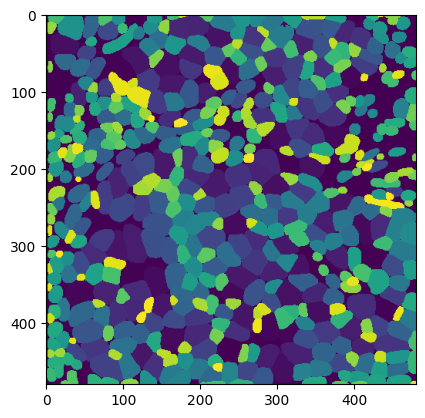

In [ ]:
# Run inference pipeline
mask = cellsam_pipeline(
    img, use_wsi=False, low_contrast_enhancement=False, gauge_cell_size=False
)

# Visualize results
plt.imshow(mask)

# DeepCell Annotation

> **Note:**  
> While using the **Zarr** package, I discovered that the latest update requires **Zarr version ≥ 2** and **Python version ≥ 3.10**.  
> Therefore, I am using **Python 3.12** as the stable compatible version.


In [ ]:
import zarr
import s3fs, zarr
import numpy as np
from cellSAM.cellsam_pipeline import cellsam_pipeline
print(f"zarr version: {zarr.__version__}")  # Using v2 consolidated store access in this environment

zarr version: 3.1.3


In [18]:
fs = s3fs.S3FileSystem(anon=True, client_kwargs={'region_name': 'us-east-1'})
store = s3fs.S3Map(root='deepcelltypes-demo-datasets/hubmap.zarr', s3=fs, check=False)

z = zarr.open_consolidated(store)  # v2 API

# Select dataset used in tutorial
k = "HBM994_PDJN_987"
ds = z[k]

# Load image (C,H,W), channel names, and mpp
img = ds["image"][:]  # channels-first
chnames = ds["image"].attrs.get("channels")
mpp = float(ds["image"].attrs.get("mpp", 1.0))

print(k, img.shape, len(chnames), mpp)

HBM994_PDJN_987 (37, 2048, 2048) 37 0.6


In [19]:
print(mpp)

0.6


**This part of the code will do the cellsam segmentation**

In [ ]:
# Cell segmentation with CellSAM


# Channels for segmentation from metadata
nuc, mem = ds.attrs["nuclear_channel"], ds.attrs["membrane_channel"]
im = np.stack(
    [img[chnames.index(nuc)], img[chnames.index(mem)]],
    axis=-1,
).squeeze()

# Format for CellSAM: 3-channel image with nuc+mem in last two channels
seg_img = np.zeros((*im.shape[:-1], 3), dtype=im.dtype)
seg_img[..., 1:] = im

mask = cellsam_pipeline(
    seg_img,
    block_size=512,
    low_contrast_enhancement=False,
    use_wsi=True,
    gauge_cell_size=False,
)

import skimage
mask, _, _ = skimage.segmentation.relabel_sequential(mask)
mask = mask.astype(np.uint32)

print("mask shape:", mask.shape, "max label:", int(mask.max()))

Total blocks: 16


0it [00:00, ?it/s]/u/sbdubey/miniconda/envs/celltools10g/lib/python3.12/site-packages/cellSAM/sam_inference.py:351: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("Low IOU threshold, ignoring mask.")
2it [00:03,  1.99s/it]/u/sbdubey/miniconda/envs/celltools10g/lib/python3.12/site-packages/cellSAM/sam_inference.py:351: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("Low IOU threshold, ignoring mask.")
3it [00:06,  2.21s/it]/u/sbdubey/miniconda/envs/celltools10g/lib/python3.12/site-packages/cellSAM/sam_inference.py:351: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("Low IOU threshold, ignoring mask.")
6it [00:16,  3.07s/it]/u/sbdubey/miniconda/envs/celltools10g/lib/python3.12/site-packages/cellSAM/sam_inference.py:351: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("Low IOU threshold, ignoring mask.")
10it [00:26,  2.59s/it]/u/sbdubey/miniconda/envs/celltools10g/lib/python3.12/site-packages/cellSAM/sam_inference.py:351: Use

mask shape: (2048, 2048) max label: 1743


In [21]:
print(mask.shape)

(2048, 2048)


In [22]:
print(f'number of channels in image {img.shape}')

number of channels in image (37, 2048, 2048)


**This is the Deep Cell Annotation of the code**

In [24]:
print(f'The shape of the input to the model is {img.shape}')

The shape of the input to the model is (37, 2048, 2048)


In [25]:
print(f'The shape of the input mask is {mask.shape}')

The shape of the input mask is (2048, 2048)


**note that channel name is a list datatype** 

In [26]:
print(f'The number of channels are : {chnames}')

The number of channels are : ['CD11C', 'CD14', 'CD16', 'CD163', 'CD20', 'CD206', 'CD3', 'CD31', 'CD4', 'CD44', 'CD45', 'CD56', 'CD57', 'CD68', 'CD8', 'CD80', 'CK7', 'DCSIGN', 'ECAD', 'FOXP3', 'GALECTIN9', 'GRB', 'H3', 'HLADR', 'HLAG', 'HO1', 'IDO', 'KI67', 'LCK', 'PD1', 'PDL1', 'SMA', 'TIGIT', 'TIM3', 'TRYPTASE', 'VIM', 'INOS']


In [36]:
print(len(chnames))

37


In [23]:
# DeepCell Types inference
import deepcell_types

model = "deepcell-types_2025-06-09"
cell_types = deepcell_types.predict(
    img,            # C,H,W from zarr
    mask,           # H,W labels
    chnames,        # channel names
    mpp,
    model_name=model,
    device_num="cpu",   # or "cuda:0"
    num_workers=1,
)

from collections import defaultdict
import pandas as pd

idx_to_pred = dict(enumerate(cell_types, start=1))
display(pd.DataFrame.from_dict(idx_to_pred, orient="index", columns=["Cell type"]))

labels_by_celltype = defaultdict(list)
for idx, ct in idx_to_pred.items():
    labels_by_celltype[ct].append(idx)

num_cells = int(mask.max())
print("Total number of cells:", num_cells)
{k: f"{len(v)} ({100*len(v)/num_cells:0.2f}%)" for k, v in labels_by_celltype.items()}


/u/sbdubey/miniconda/envs/celltools10g/lib/python3.12/site-packages/deepcell_types/dataset.py:42: UserWarning: Channel CD14 is not in the channel mapping. This channel will be masked out.
  warnings.warn(
/u/sbdubey/miniconda/envs/celltools10g/lib/python3.12/site-packages/deepcell_types/dataset.py:42: UserWarning: Channel CD80 is not in the channel mapping. This channel will be masked out.
  warnings.warn(
/u/sbdubey/miniconda/envs/celltools10g/lib/python3.12/site-packages/deepcell_types/dataset.py:42: UserWarning: Channel DCSIGN is not in the channel mapping. This channel will be masked out.
  warnings.warn(
/u/sbdubey/miniconda/envs/celltools10g/lib/python3.12/site-packages/deepcell_types/dataset.py:42: UserWarning: Channel ECAD is not in the channel mapping. This channel will be masked out.
  warnings.warn(
/u/sbdubey/miniconda/envs/celltools10g/lib/python3.12/site-packages/deepcell_types/dataset.py:42: UserWarning: Channel FOXP3 is not in the channel mapping. This channel will be m

,Cell type
1,Myofibroblast
2,Fibroblast
3,EVT
4,Myofibroblast
5,EVT
...,...
1739,NK
1740,NK
1741,EVT
1742,NK


Total number of cells: 1743


{'Myofibroblast': '102 (5.85%)',
 'Fibroblast': '325 (18.65%)',
 'EVT': '656 (37.64%)',
 'Macrophage': '206 (11.82%)',
 'NK': '271 (15.55%)',
 'Epithelial': '56 (3.21%)',
 'Endothelial': '45 (2.58%)',
 'SmoothMuscle': '50 (2.87%)',
 'Stellate': '10 (0.57%)',
 'Melanocyte': '4 (0.23%)',
 'CD4T': '6 (0.34%)',
 'NKT': '6 (0.34%)',
 'CD8T': '3 (0.17%)',
 'HSEC': '2 (0.11%)',
 'Microglial': '1 (0.06%)'}